In [1]:
# imports
from matplotlib import pyplot as plt
import os
import random

In [2]:
# include the trading strategies
%run trading_strategies.ipynb

In [3]:
# define the path where the data is persisted
STORAGE_PATH = "../../persisted_data/feather/{}_normalized.feather"
STORAGE_PATH_MODELS = "../../persisted_data/models/{}"
STORAGE_PLOTS = "../../persisted_data/plots/{}"
ASSET_LIST_PATH = "../../persisted_data/asset_lists/{}.csv"

In [4]:
def load_data_set(name):
    data = pd.read_feather(STORAGE_PATH.format(name))
    return data

def load_data_sets(asset_list, sample_size = 100):
    tickers = list(pd.read_csv(ASSET_LIST_PATH.format(asset_list), usecols=["Ticker", "Name"])["Ticker"])
    tickers = list(filter(lambda ticker: os.path.isfile(STORAGE_PATH.format(ticker)) , tickers))
    random.shuffle(tickers)
    asset_data = {}
    size = 0
    for ticker in tickers:
        if size < sample_size:
            data = load_data_set(ticker)
            if data.shape[0] > 2000:
                asset_data[ticker] = data
                size += 1
    return pd.Series(asset_data)

In [5]:
# load the stock data
value_stock = load_data_set("IBM")
growth_stock = load_data_set("AAPL")

In [6]:
# load some data sets for different countries
finland_assets = load_data_sets("finland")
austria_assets = load_data_sets("austria")
southkorea_assets = load_data_sets("southkorea")

In [7]:
# find all indicator columns
all_indicators = value_stock.columns[~value_stock.columns.str.contains("future|current", regex=True)]

# Portfolio performance simulation

The following section defines all the functionally needed to evaluate stock trading strategies. The simulation calculates the changes happening in terms of price changes for each individual position over time.

This simulation is not considering any transaction costs, but only the theoretical portfolio value when holding certain stock positions according to some trading rule. Also a theoretical rebalance of the positions is applied daily, which is not feasable in reality. Therefore the results are not the actual performance, which could be achieved in realistic situtions.

In [8]:
# extract the price changes from each stock  and pad them with zeros
# such that the series has the same length for all stocks
def get_price_changes(stock, max_trading_days):
    # retrieve the length of this stock
    size = stock.shape[0]
    # determine the changes in price normalized by the previous price
    price_changes = np.diff(stock["current_price"]) / stock["current_price"][:size - 1]
    # set the changes to zero if no data exists
    return np.append(np.zeros(np.max(max_trading_days - size, 0)), price_changes)

# extraxt the positions taken in the stock according to the provided trading rule
def get_portfolio_positions(stock, rule, max_trading_days, rebalance_interval=1):
    # retrieve the length of this stock
    size = stock.shape[0]
    # calculate the position for each time point using the trading rule
    position = rule(stock)
    # not position can be taken, before the stock data exists
    return np.append(np.zeros(max_trading_days - size), position)[:max_trading_days - 1]

In [9]:
# a function simulating the performance of a trading rule applied to multiple stocks
def simulate_performance(stock_data, rule, rebalance_interval=1, trading_cost=0, leverage=1, weights=None):
    # get the length of the largest data set in trading days
    trading_days = np.max(stock_data.map(lambda stock: stock.shape[0]))
    
    # calculate the changes for each stock and transform the series of data frames into one data frame
    price_changes = stock_data.apply(get_price_changes, args=(trading_days, ))
    price_changes = pd.DataFrame(price_changes.values.tolist(), index=price_changes.index).T.values
    
    # calculate the positions in the stock and transform the series of data frames into one data frame
    portfolio_positions = stock_data.apply(get_portfolio_positions, args=(rule, trading_days, rebalance_interval, ))
    portfolio_positions = pd.DataFrame(portfolio_positions.values.tolist(), index=portfolio_positions.index).T

    if weights is None:
        # no special weights are chosen, chose equal weights
        weights = np.ones(portfolio_positions.shape[1]) / portfolio_positions.shape[1]
    
    # ensure that the sum of weights is 1
    weights = weights / np.sum(weights)
    
    # calculate the theoretical positions chosen by the trading rule based on the weights
    portfolio_positions = portfolio_positions.values * weights
    
    # this porfolio consists of the portfolio compoenents and and cash (or any asset that does not move)
    cash = np.ones(trading_days - 1)
    portfolio_components = np.zeros_like(portfolio_positions)
    
    # store the trading volume cause by the strategy
    volume = np.zeros(trading_days - 1)
    portfolio_total = np.copy(volume)
    
    # update the value of the portfolio iteratively
    for i in range(1, trading_days - 1):
        portfolio_components[i] = portfolio_components[i - 1] * (1 + leverage * price_changes[i, :])
        cash[i] = cash[i - 1]
        if i % rebalance_interval == 0: 
            # rebalance the portfolio
            total = np.sum(portfolio_components[i]) + cash[i]
            portfolio_components[i] = total * portfolio_positions[i]
            cash[i] = total - np.sum(portfolio_components[i]) 
            
            # substract transaction cost from positions
            volume[i] = np.sum(np.abs((portfolio_components[i - 1] - portfolio_components[i])))
            cash[i] -= volume[i] * trading_cost
        
    # return the sum of portfolio componenets and positions in the stocks
    return np.sum(portfolio_components, axis=1) + cash, portfolio_positions * leverage, volume

In [10]:
# plot all portfolio developments
def plot_performance(strategies, title="Performance comparison of multiple trading strategies"):
    plt.figure(figsize=(15,8))
    for name, performance in strategies.items():
        # plot each strategy performance
        plt.plot(np.arange(len(performance)), performance, label=name)
    
    # label the chart
    plt.title(title)
    plt.legend()
    plt.xlabel("Trading days")
    plt.ylabel("Portfolio change")
    plt.show()

In [11]:
# create a set of strategies, simulate and plot them
def compare_strategies_portfolio(stock_data, strategies, rebalance_interval=1, trading_cost=0, leverage=1):
    # retrive information about the stock charts
    stock_data_lengths = stock_data.map(lambda stock: stock.shape[0])
    longest_trading_history = np.max(stock_data_lengths)
    # calculate the average leverage for the buy and hold strategy
    leverage_buy_and_hold = np.sum(stock_data_lengths) / (longest_trading_history * len(stock_data_lengths))
    
    # always display the rebalancing strategy for reference, if more than one stock is given as input
    if len(stock_data) > 1:
        strategies["rebalancing"] = lambda stock : np.ones(stock.shape[0] - 1) / leverage
        
    # retrieve the price data from each stock, prepend ones for missing data
    current_price = stock_data.map(lambda stock: pd.concat(
        [pd.Series(np.ones(longest_trading_history - stock.shape[0])), stock["current_price"]], 
        ignore_index=True)).tolist()
    current_price = pd.concat(current_price, axis=1)
    
    # initialize the portfolio performances with the buy and hold strategy
    performances = {
        "buy and hold\nleverage: {:.2f}\nvolume: {:.2f}".format(leverage_buy_and_hold, 0):
        np.mean(current_price, axis=1).values
    }

    # iteratively calculate the performance of all special strategies
    for name, strategy in strategies.items():
        performance, positions, volume = simulate_performance(stock_data, strategy, 
                                                              rebalance_interval=rebalance_interval, 
                                                              trading_cost=trading_cost, 
                                                              leverage=leverage)
        mean_leverage = np.mean(np.sum(positions, axis=1))
        performances["{}\nleverage: {:.2f}\nvolume: {:.2f}".format(name, mean_leverage, np.sum(volume))] = performance

    plot_performance(performances)

In [12]:
# a help function used when only working with one stock ticker
def compare_strategies_individual(stock, chosen_strategies, rebalance_interval=1, trading_cost=0, leverage=1):
    stock_data = pd.Series({"stock": stock})
    compare_strategies_portfolio(stock_data, chosen_strategies, rebalance_interval=rebalance_interval, trading_cost=trading_cost, leverage=leverage)

# Individual stock experiments:
In order to immediately see the effect of a certain strategy, it is applied to one single stock.
For this analysis, all the strategies are applied to a 'value' stock and a 'growth' stock. They act fundamentally differently and demonstrate one problem for any trading strategy: There is no trading rule working for all situation in all markets.

The chosen stock tickers for the individual comparison are:
- IBM (International Business Machines)
- AAPL (Apple Inc.)

IBM is a known value stock that does not grow very much, but rather moves up and down in cycles.

Apple is a popular and one of the most successful companies growing rapidly. 

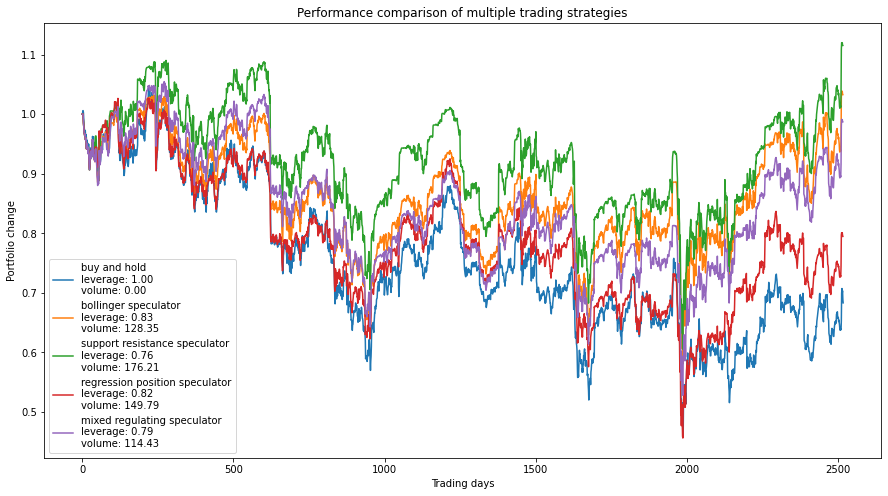

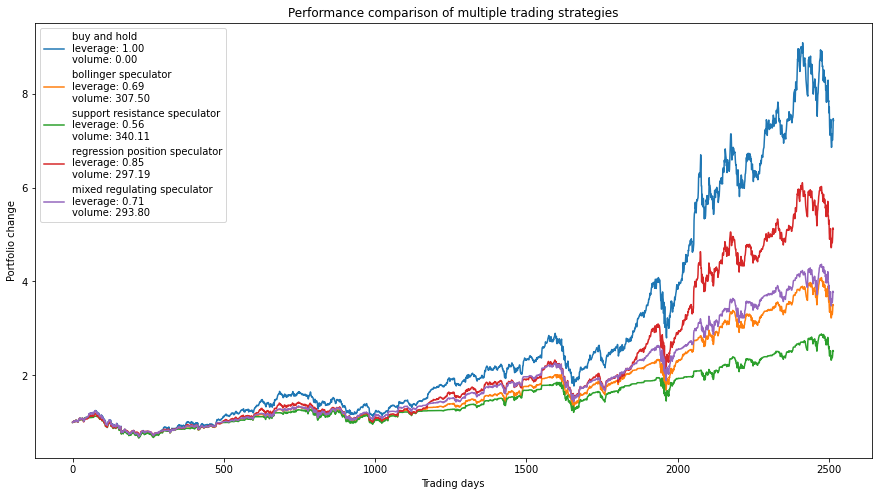

In [13]:
# try out the regulating speculator strategies
compare_strategies_individual(value_stock, regulating_speculator_strategies)
compare_strategies_individual(growth_stock, regulating_speculator_strategies)

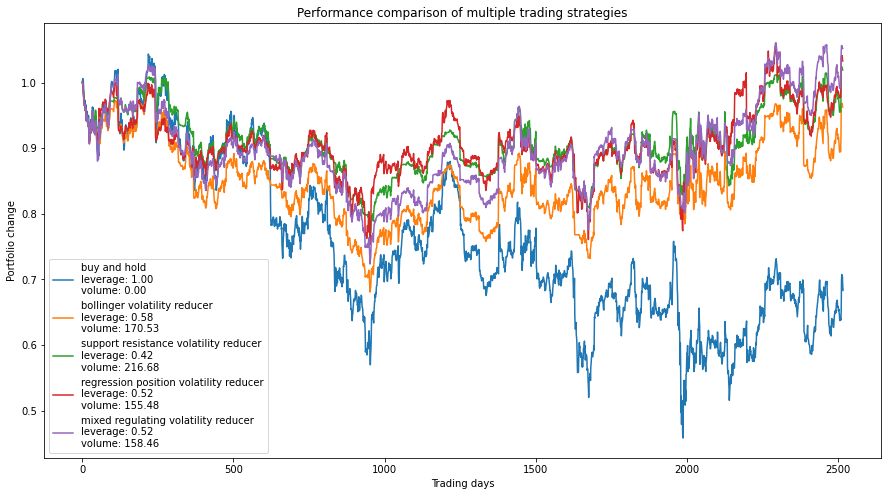

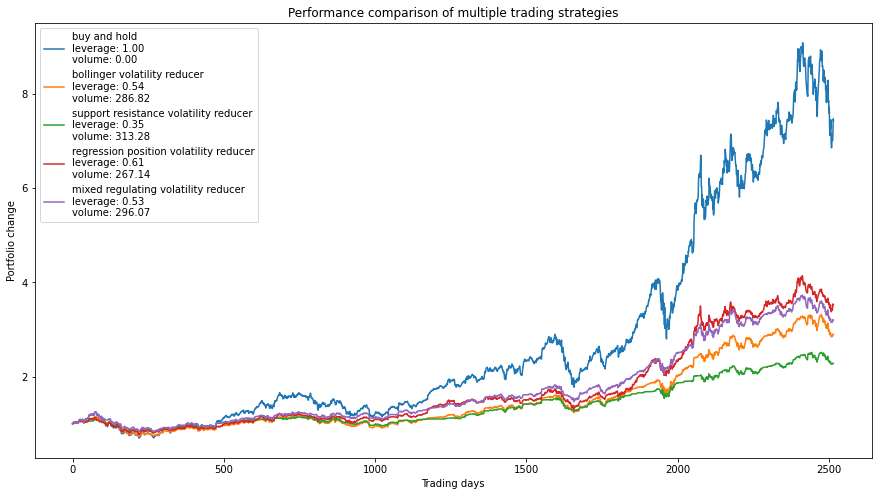

In [14]:
# try out the regulating speculator strategies
compare_strategies_individual(value_stock, volatility_reducer_strategies)
compare_strategies_individual(growth_stock, volatility_reducer_strategies)

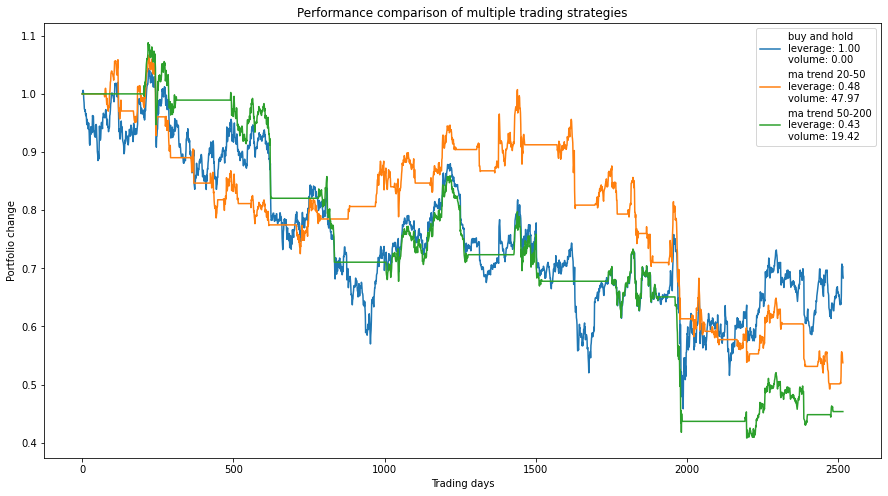

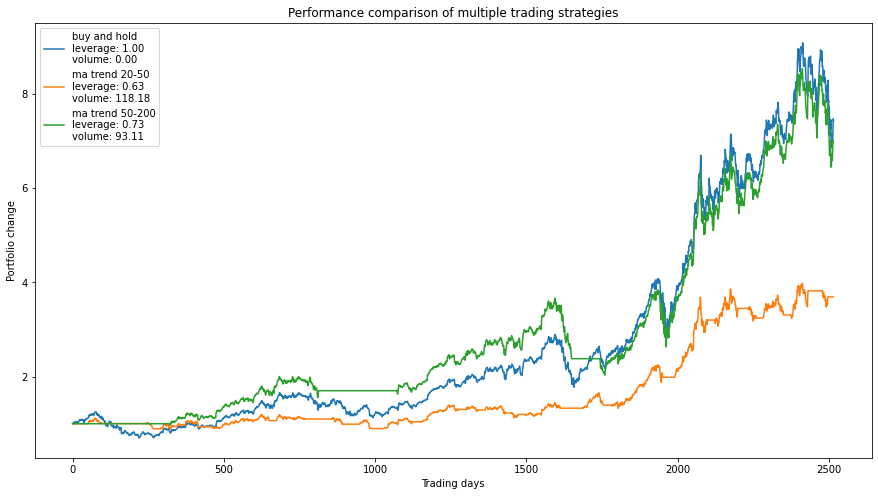

In [15]:
# try out the trendfollower
compare_strategies_individual(value_stock, trend_follower_strategies)
compare_strategies_individual(growth_stock, trend_follower_strategies)

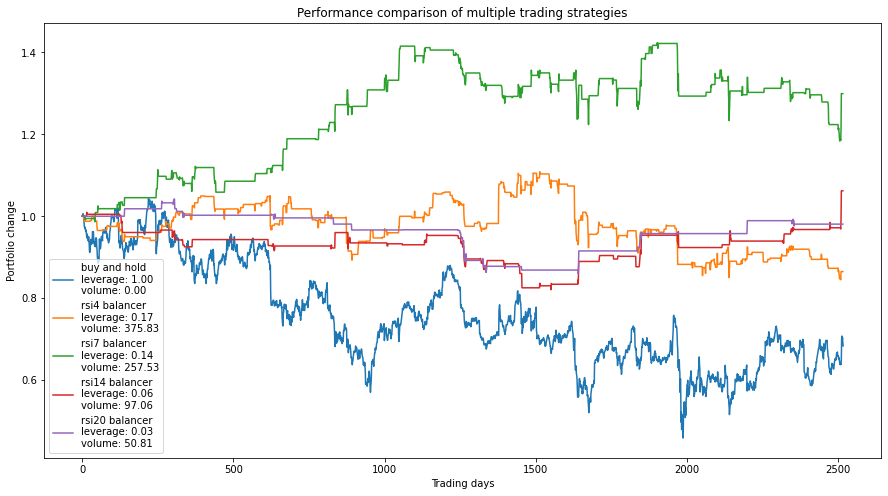

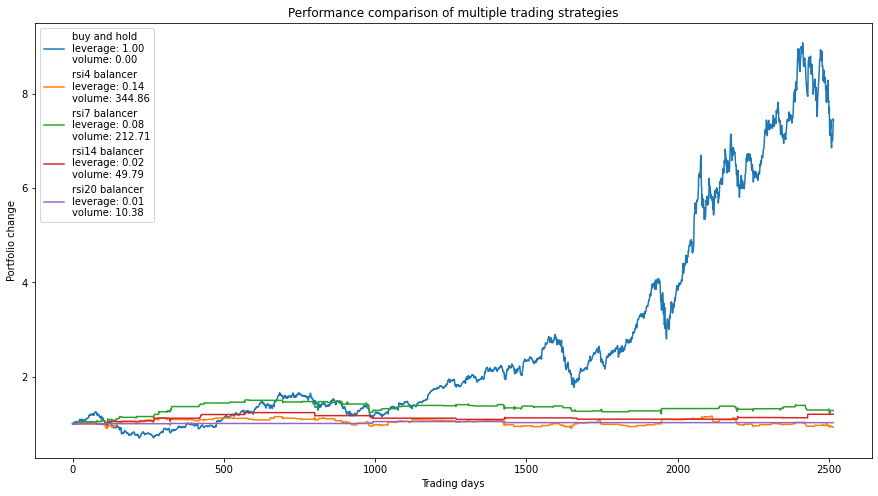

In [16]:
# try out the rsi balancer
compare_strategies_individual(value_stock, rsi_strategies)
compare_strategies_individual(growth_stock, rsi_strategies)

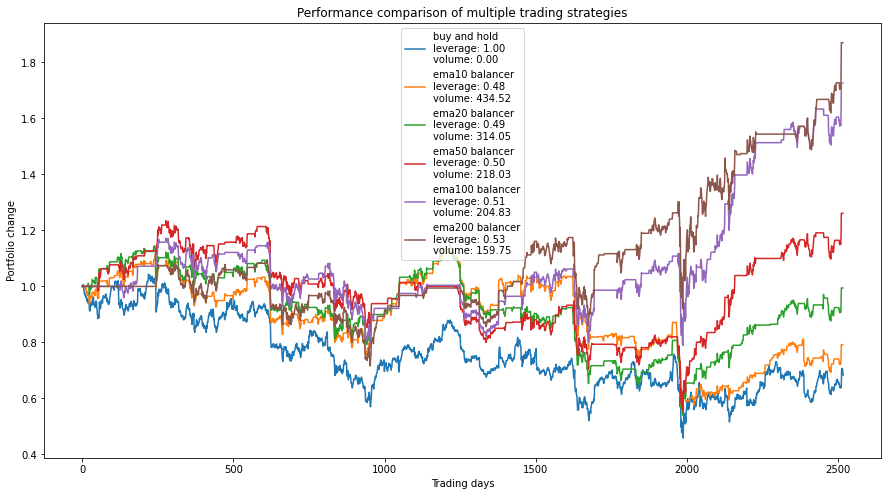

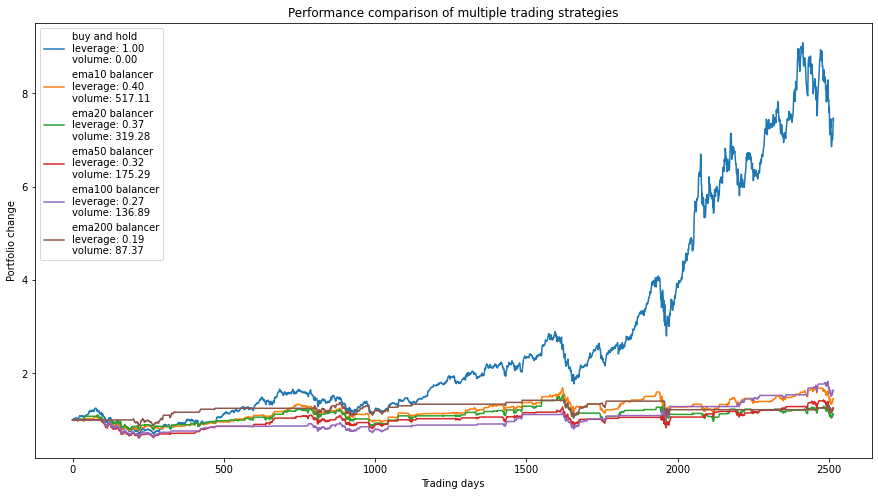

In [17]:
# try out the ema balancer
compare_strategies_individual(value_stock, ema_strategies)
compare_strategies_individual(growth_stock, ema_strategies)

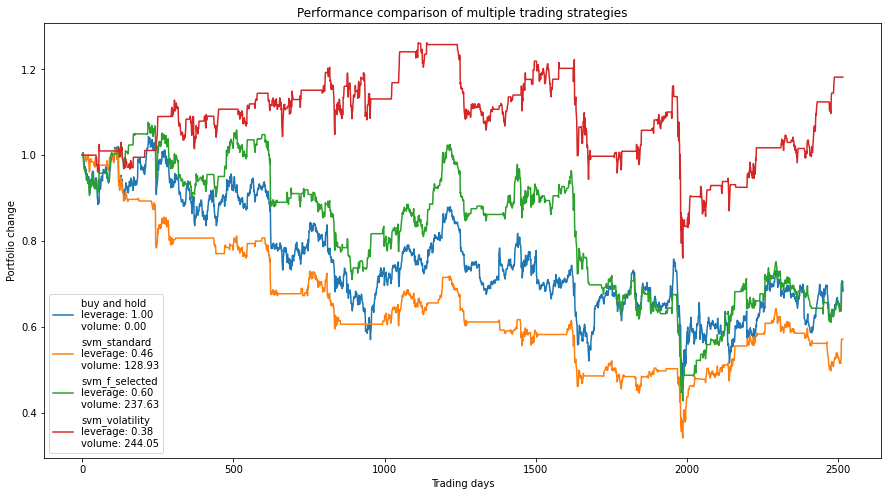

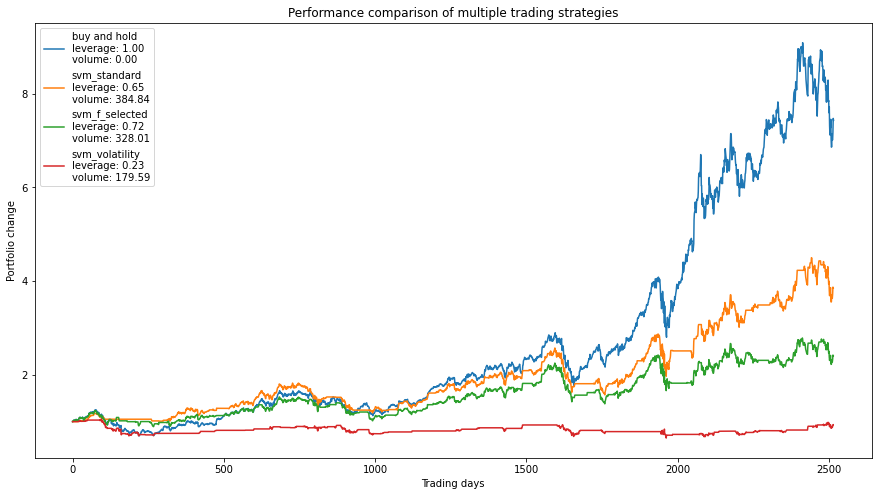

In [18]:
# try out the svm predictor
compare_strategies_individual(value_stock, svm_strategies)
compare_strategies_individual(growth_stock, svm_strategies)

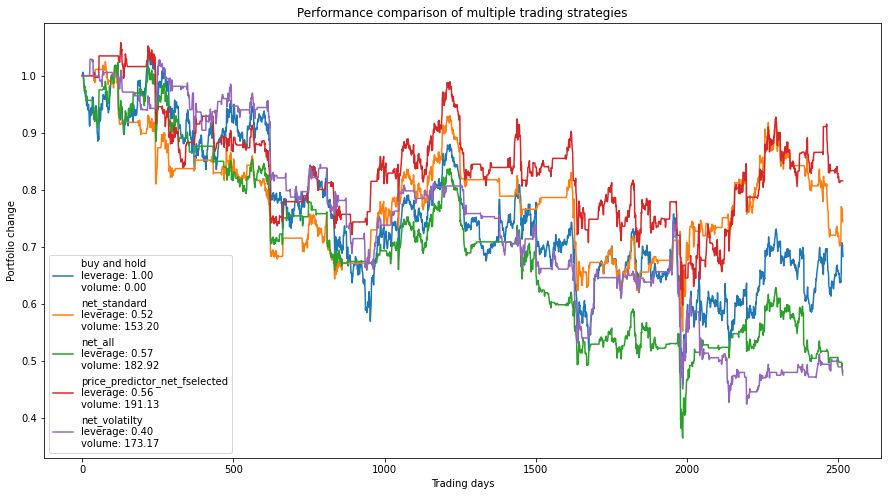

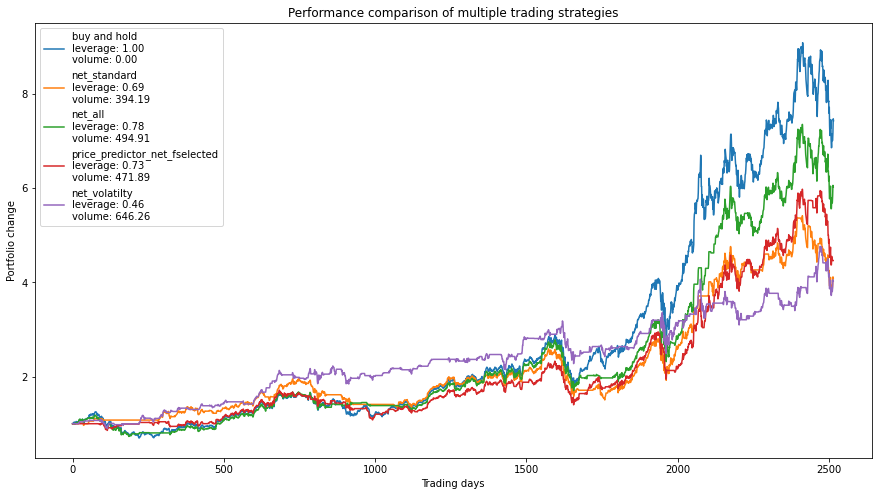

In [19]:
# try out the neural network classifier
compare_strategies_individual(value_stock, net_strategies)
compare_strategies_individual(growth_stock, net_strategies)

# Portfolio experiments Finland:

The value of a trading strategy could be automated selection of stocks which are held for each time period. To demonstratethis behavior, a number of Finnish stocks form the Helsinki Stock Exchanges are simulated with the use of the trading strategies.

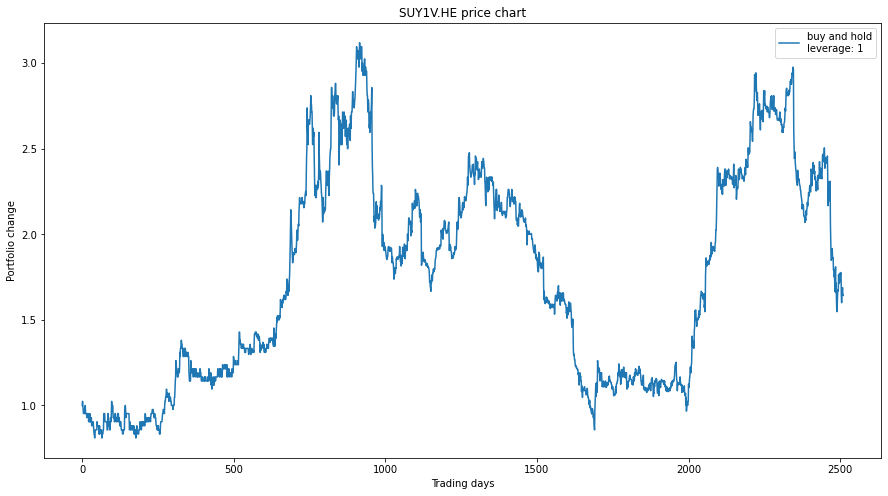

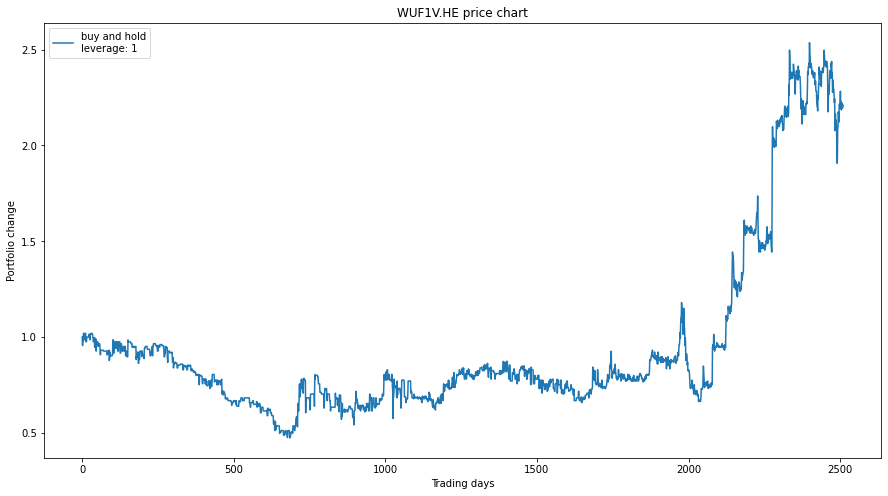

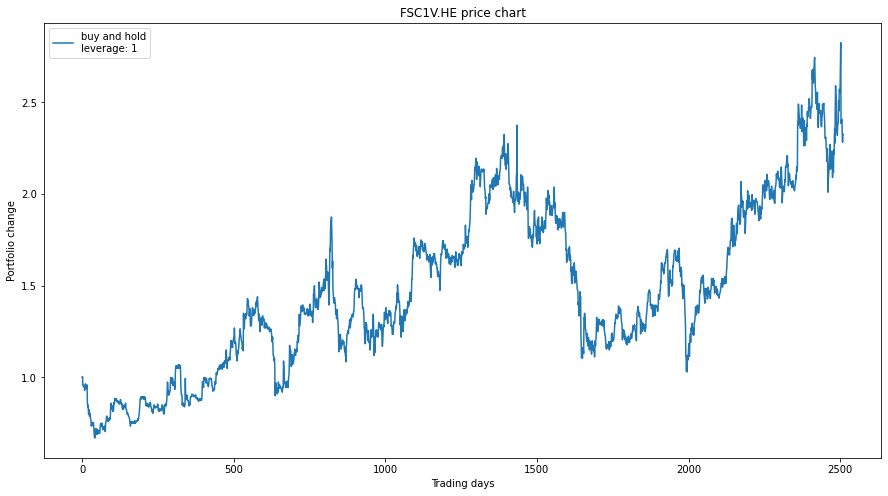

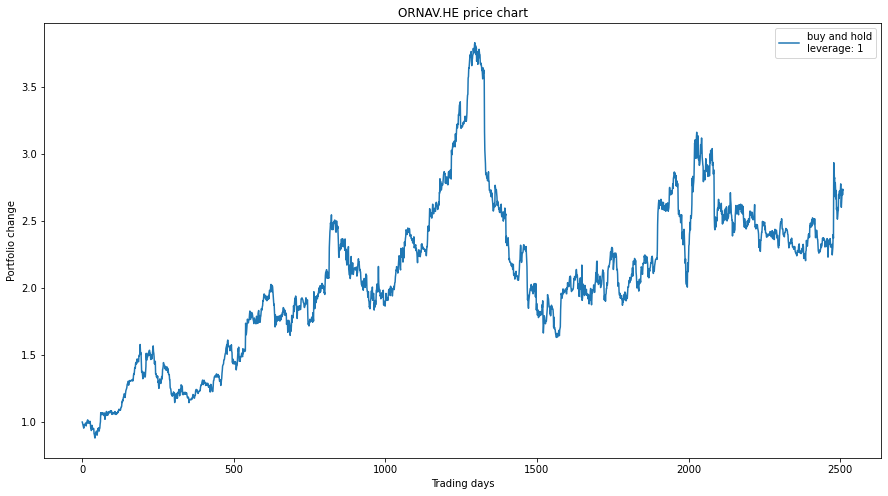

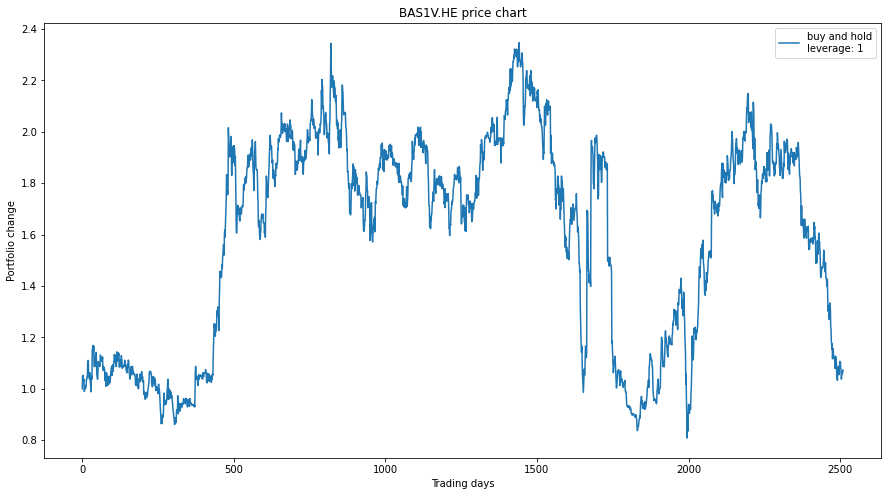

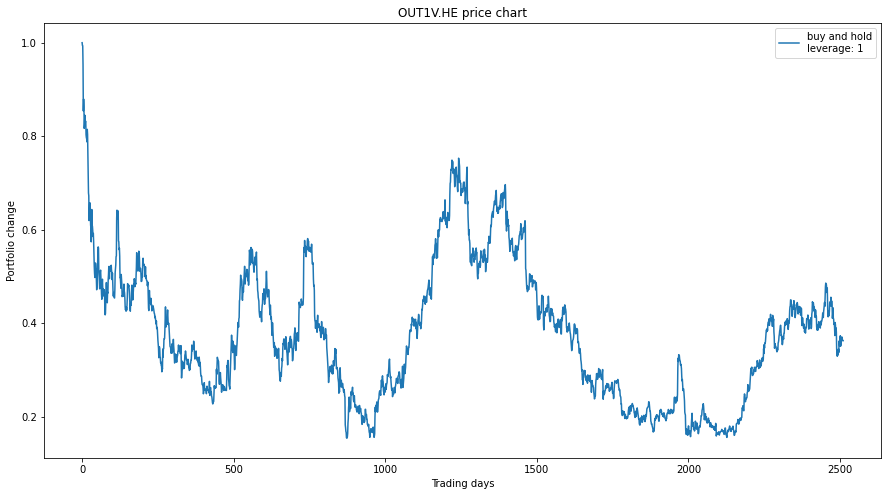

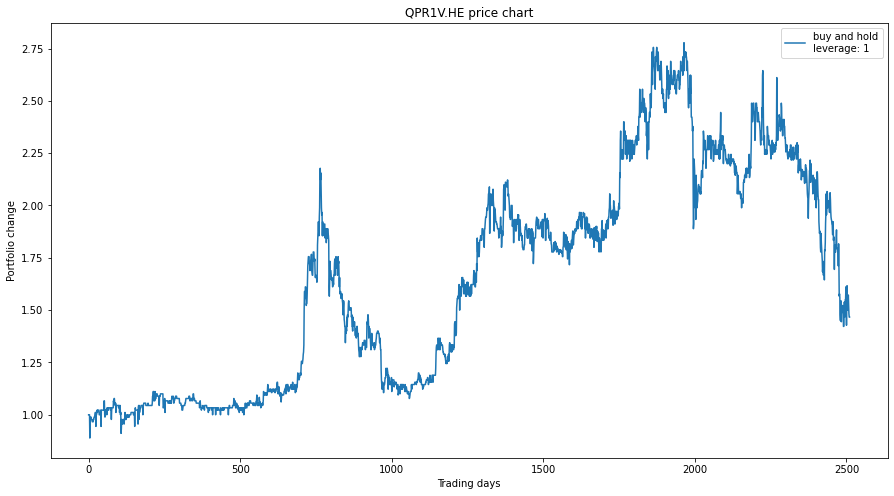

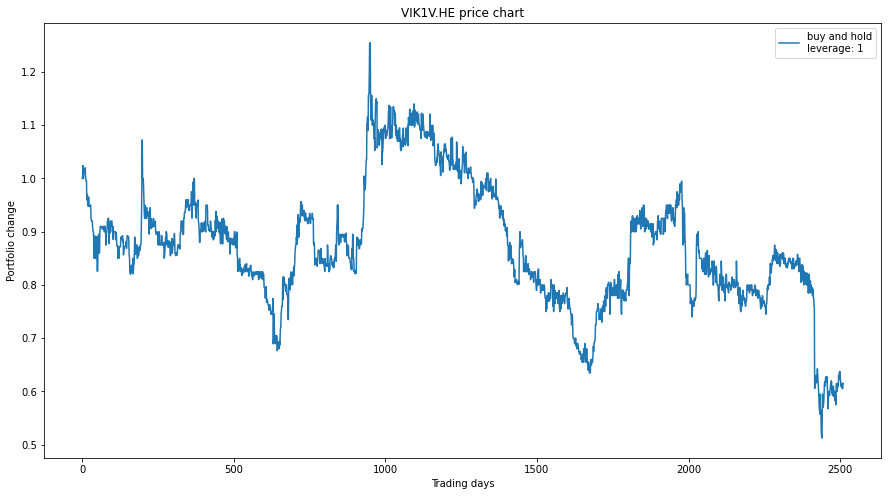

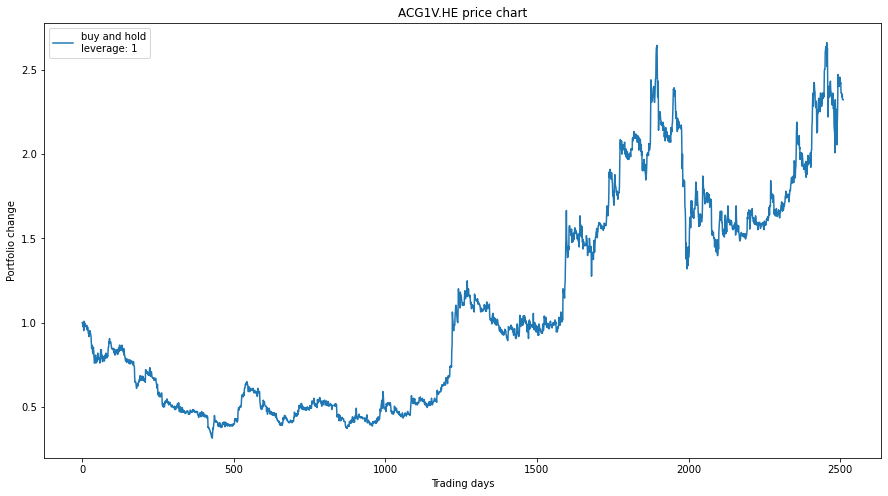

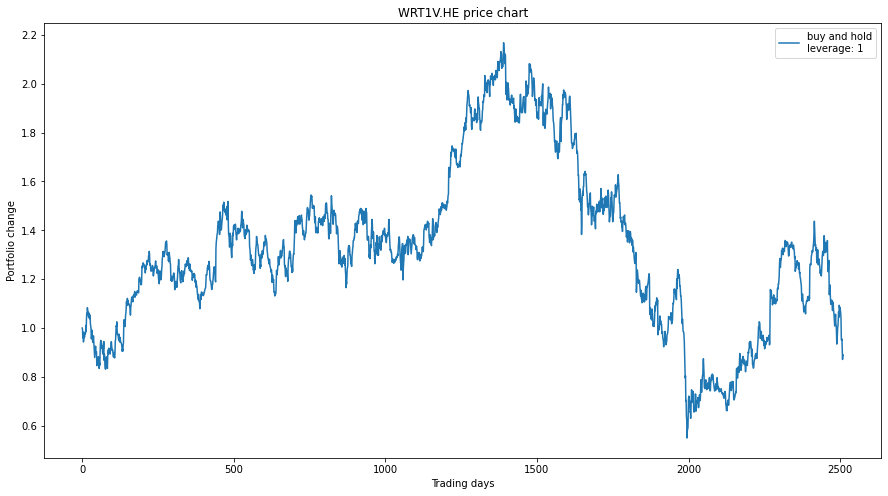

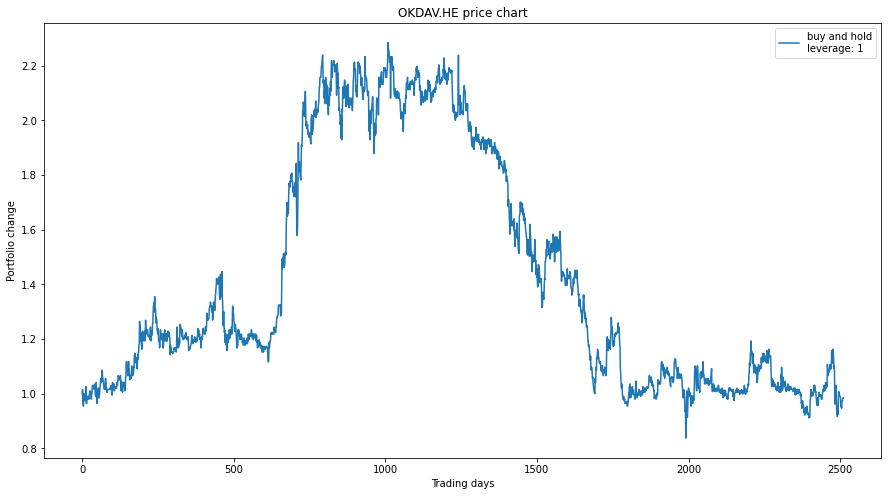

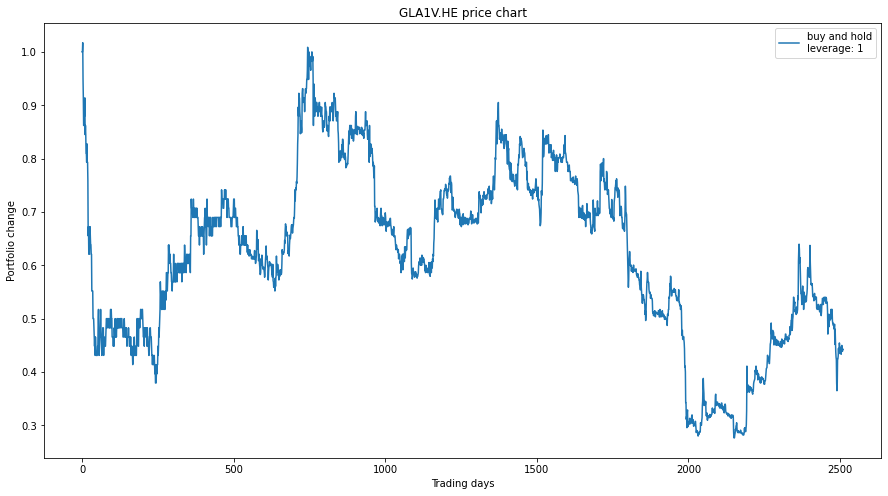

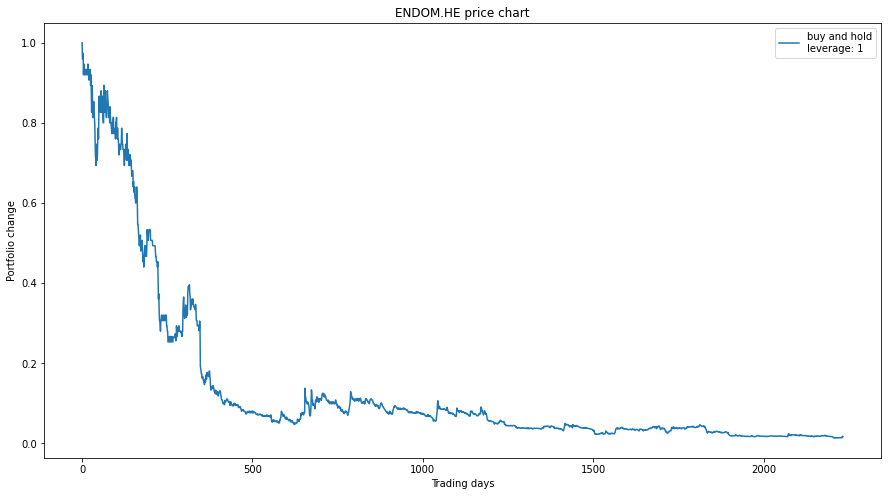

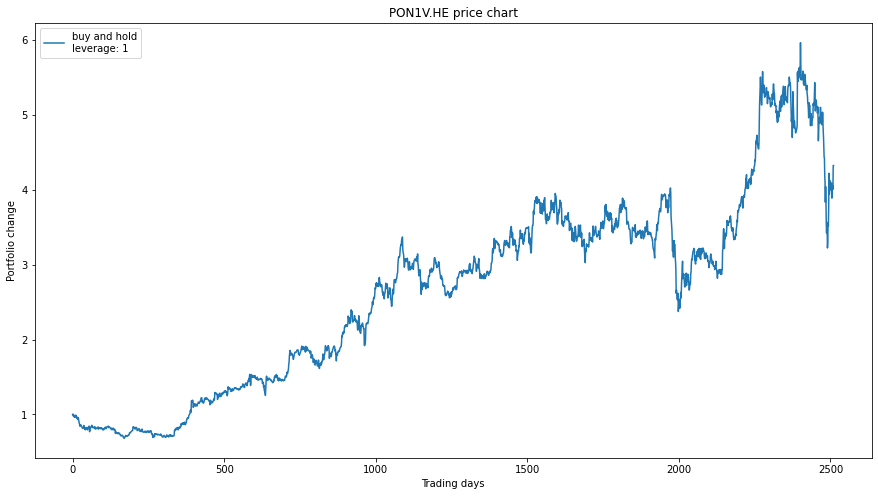

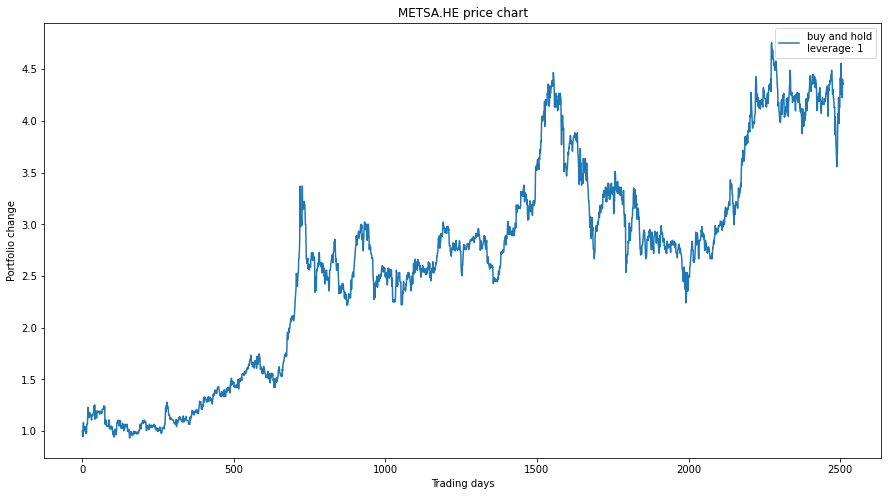

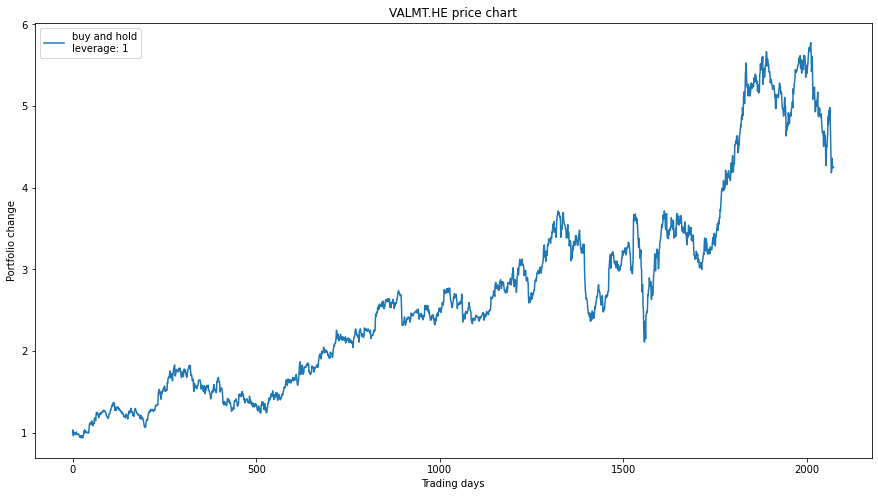

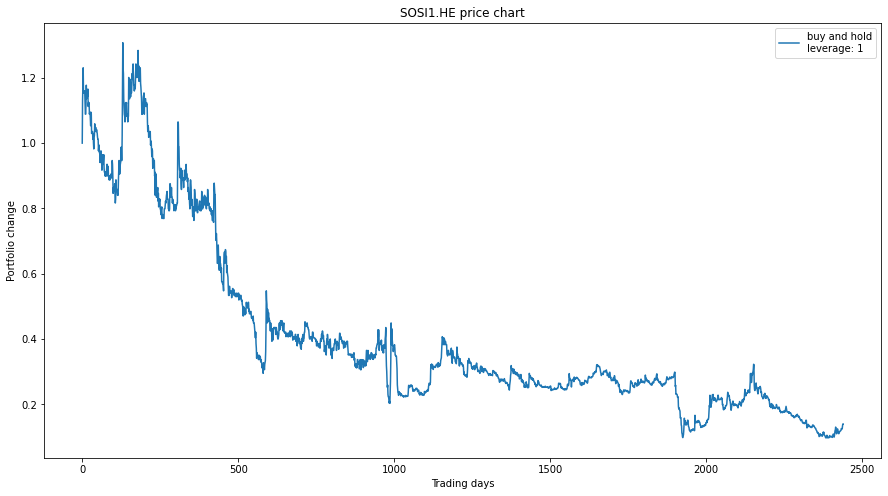

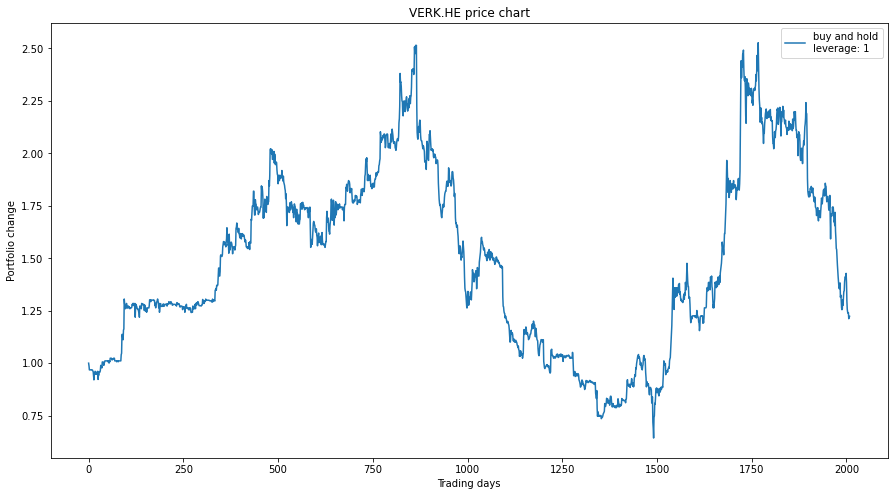

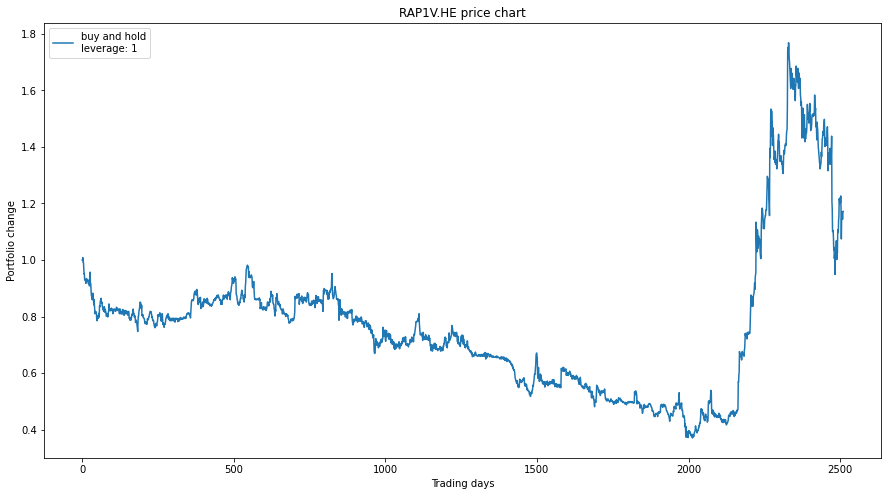

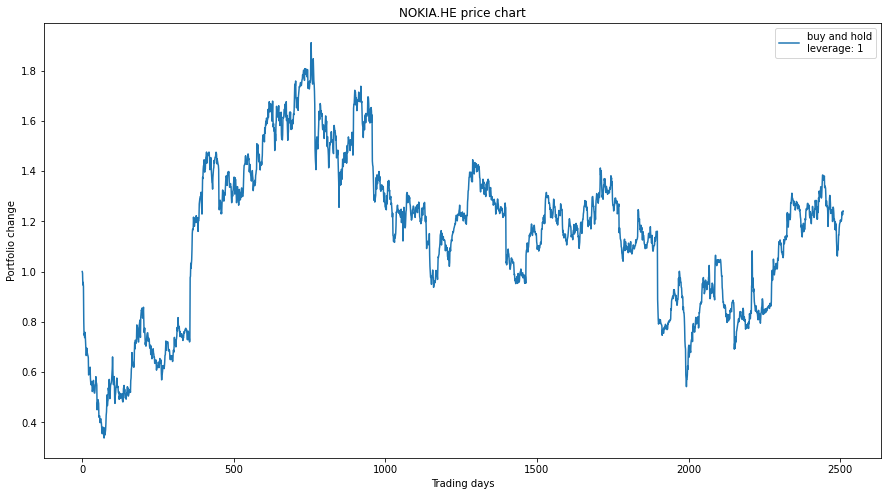

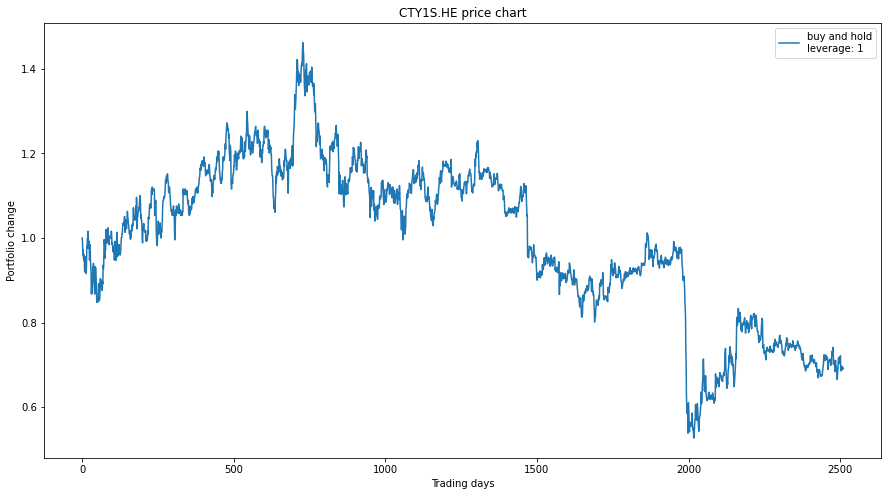

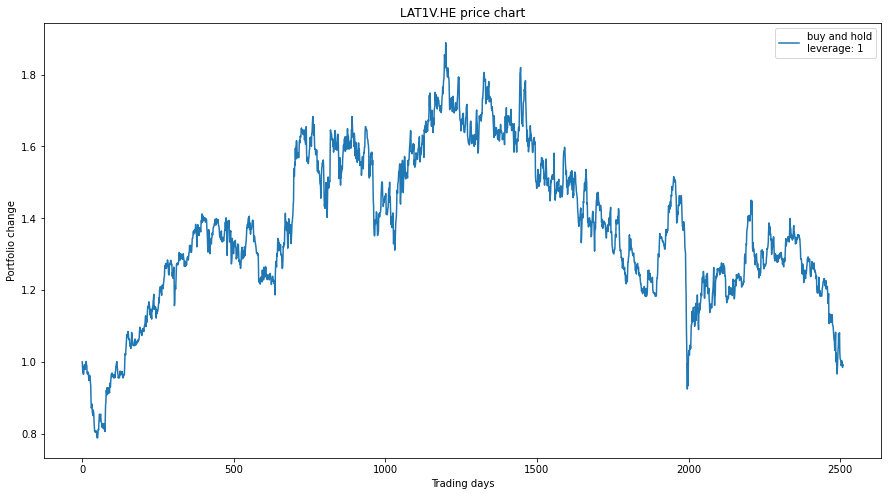

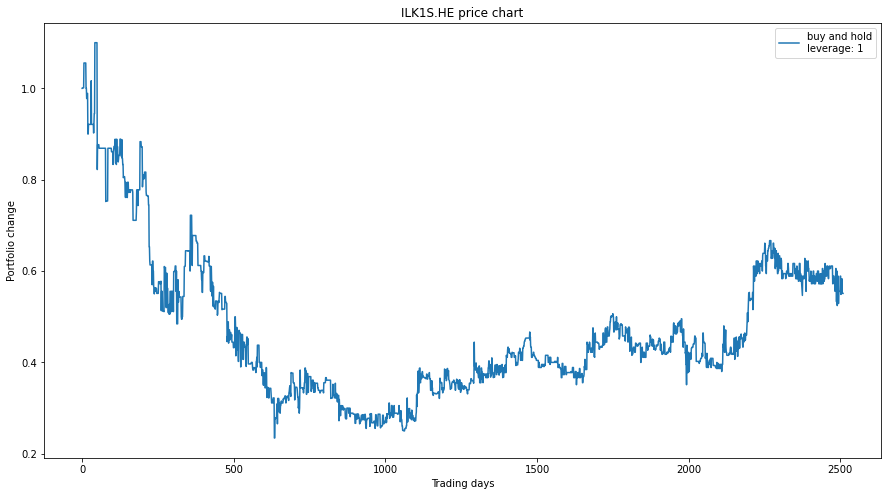

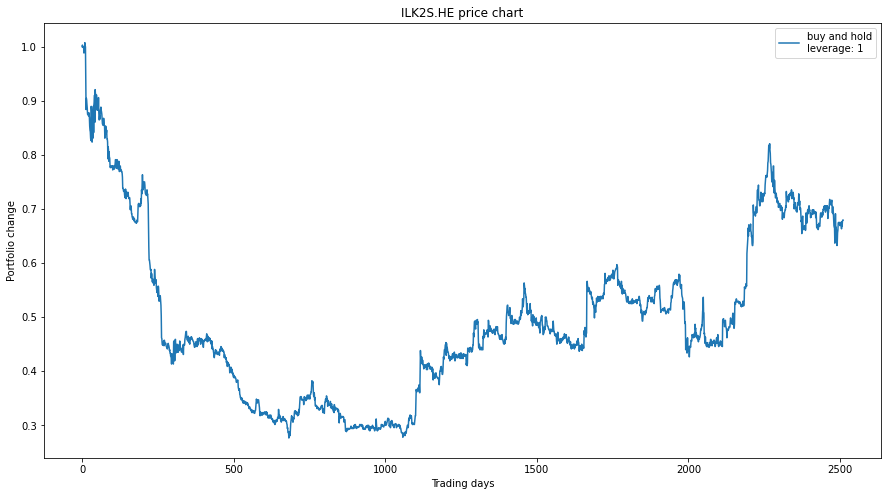

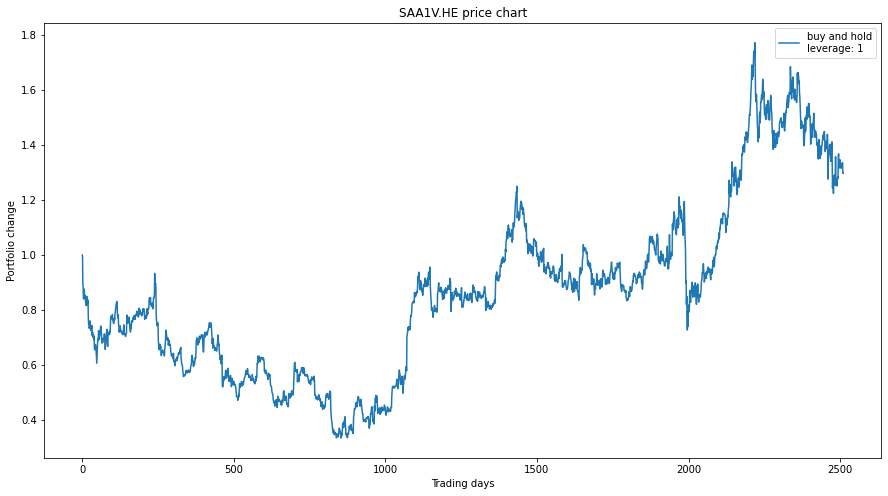

In [20]:
# show all the individual stock charts
for name, chart in finland_assets.items():
    strategy = {
        "buy and hold\nleverage: {}".format(1): chart["current_price"]
    }
    plot_performance(strategy, "{} price chart".format(name))

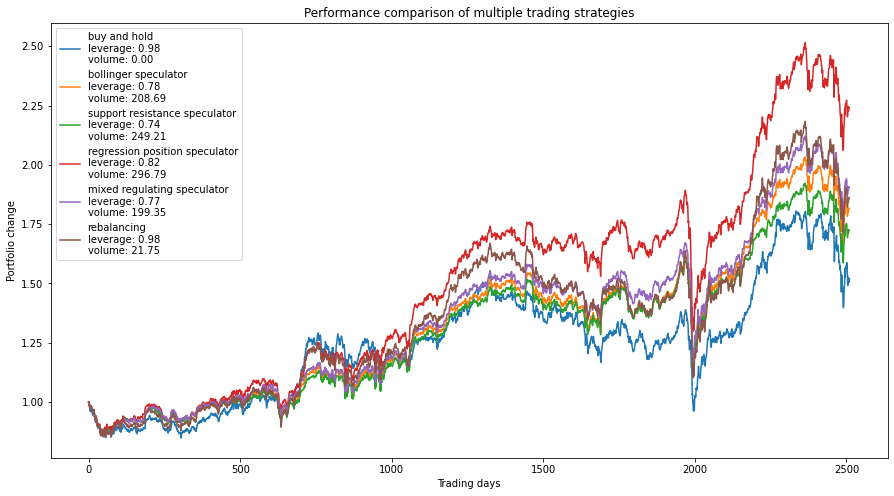

In [21]:
compare_strategies_portfolio(finland_assets, regulating_speculator_strategies)

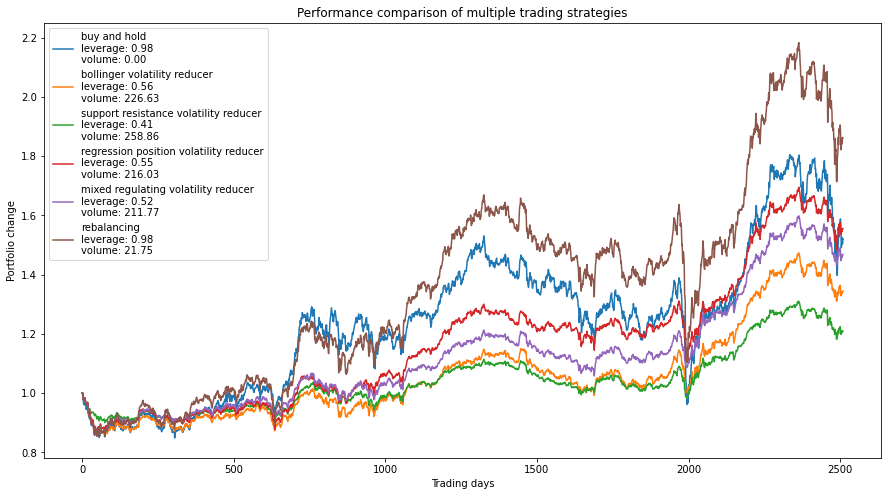

In [22]:
compare_strategies_portfolio(finland_assets, volatility_reducer_strategies)

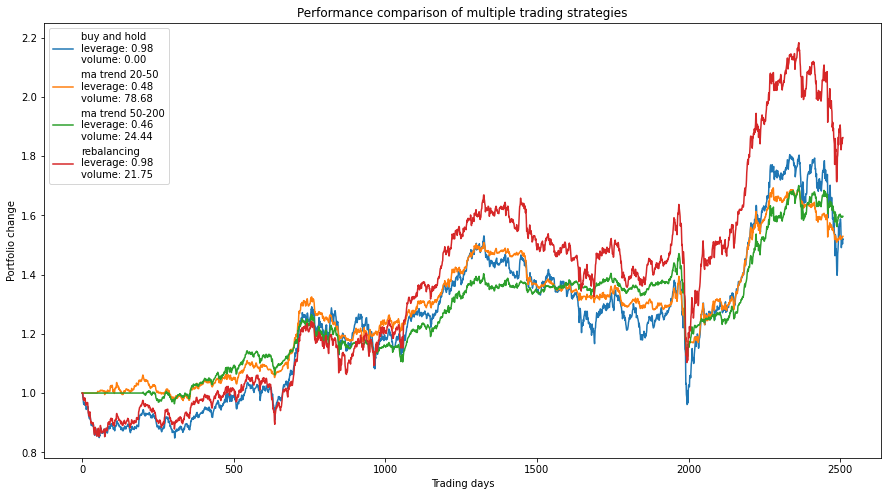

In [23]:
compare_strategies_portfolio(finland_assets, trend_follower_strategies)

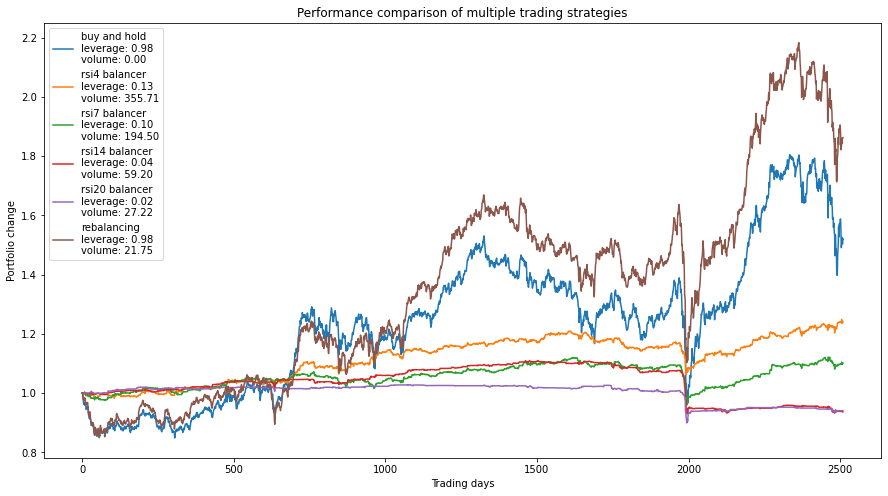

In [24]:
compare_strategies_portfolio(finland_assets, rsi_strategies)

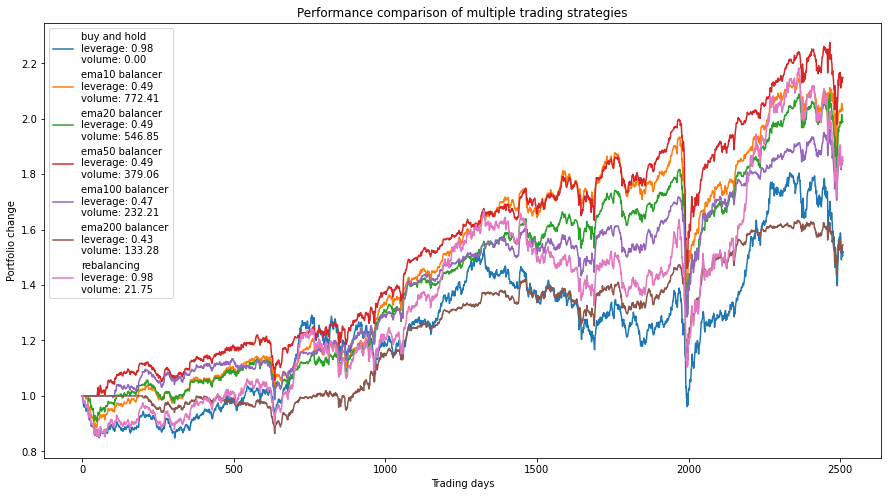

In [25]:
compare_strategies_portfolio(finland_assets, ema_strategies)

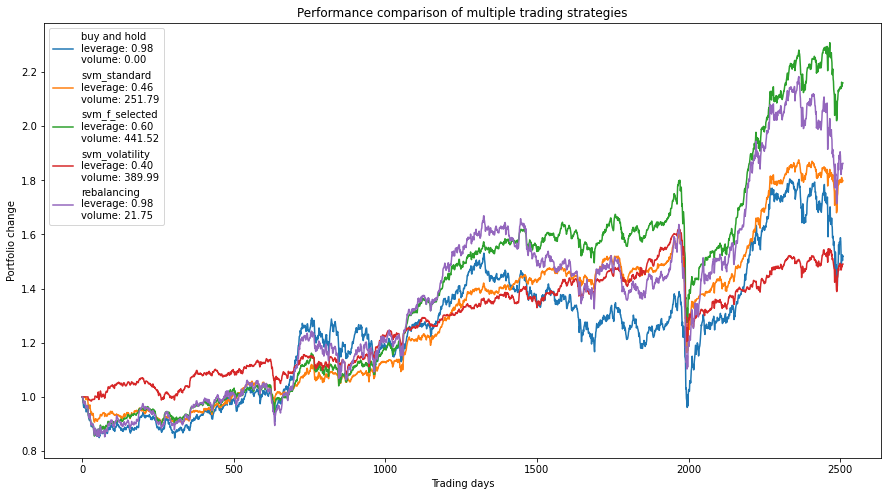

In [26]:
compare_strategies_portfolio(finland_assets, svm_strategies)

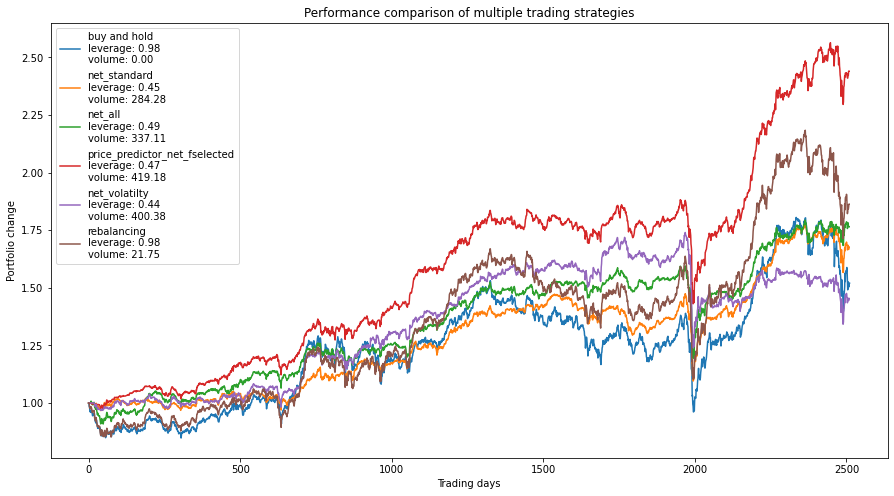

In [27]:
compare_strategies_portfolio(finland_assets, net_strategies)

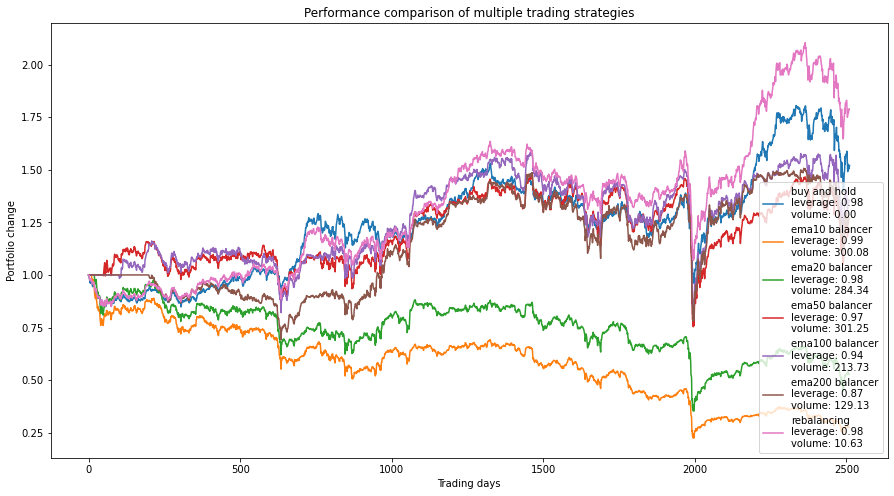

In [28]:
compare_strategies_portfolio(finland_assets, ema_strategies, trading_cost=0.005, leverage=2)

# South Korea:

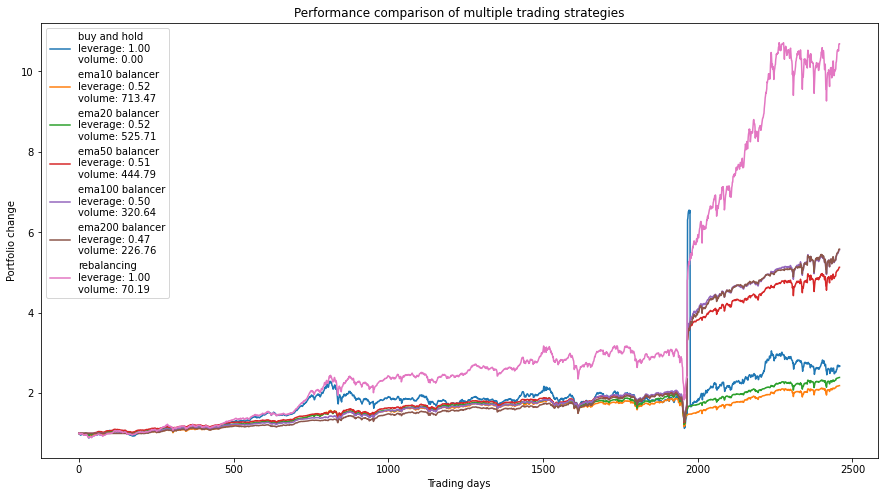

In [29]:
compare_strategies_portfolio(southkorea_assets, ema_strategies)

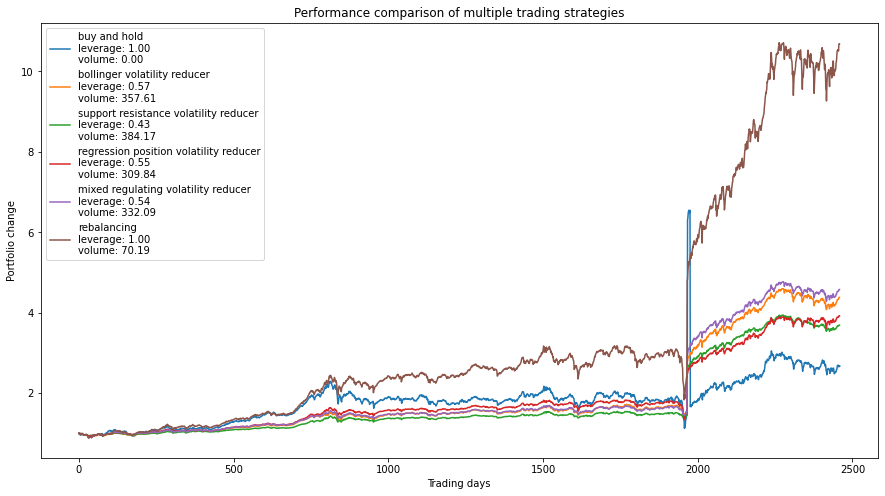

In [30]:
compare_strategies_portfolio(southkorea_assets, volatility_reducer_strategies)

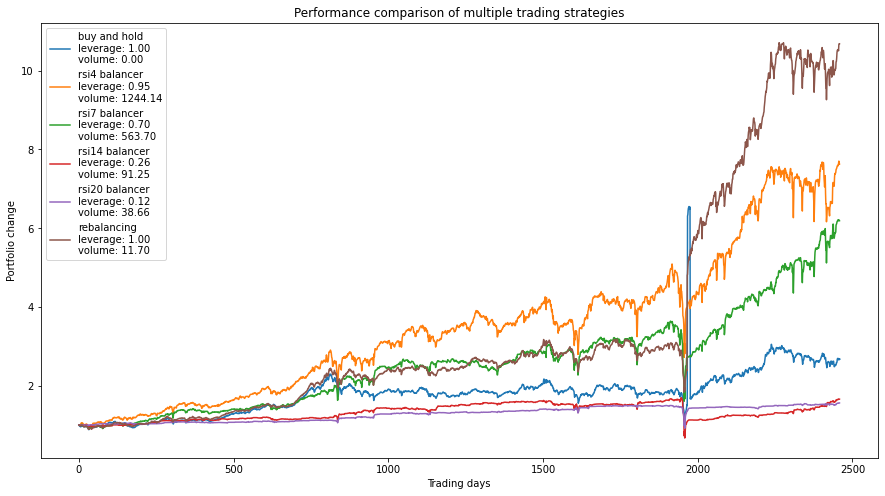

In [31]:
compare_strategies_portfolio(southkorea_assets, rsi_strategies, leverage=6)

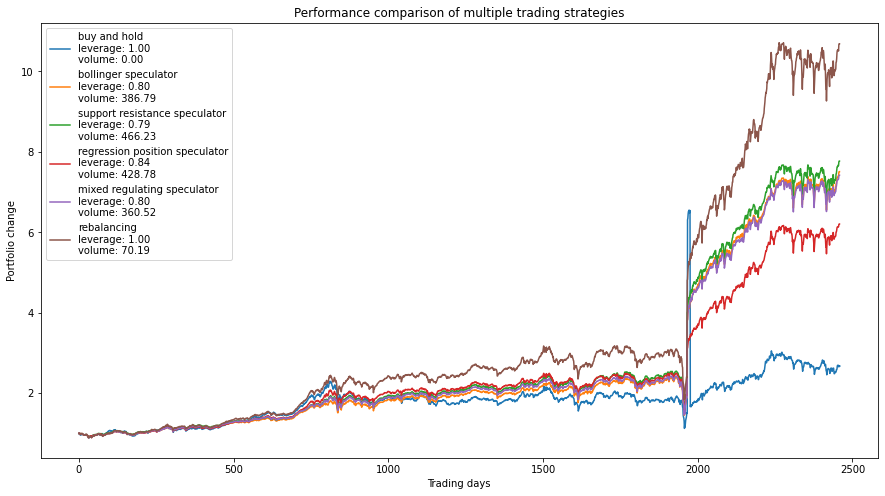

In [32]:
compare_strategies_portfolio(southkorea_assets, regulating_speculator_strategies)

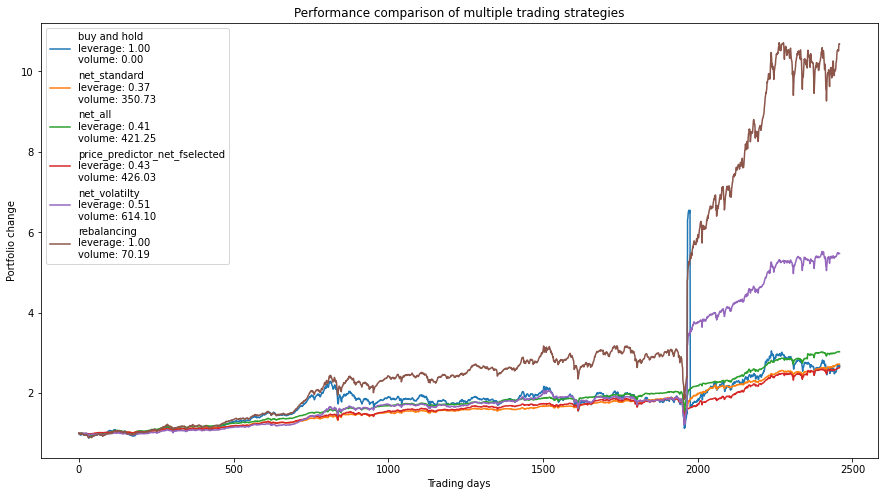

In [33]:
compare_strategies_portfolio(southkorea_assets, net_strategies)

# Austria

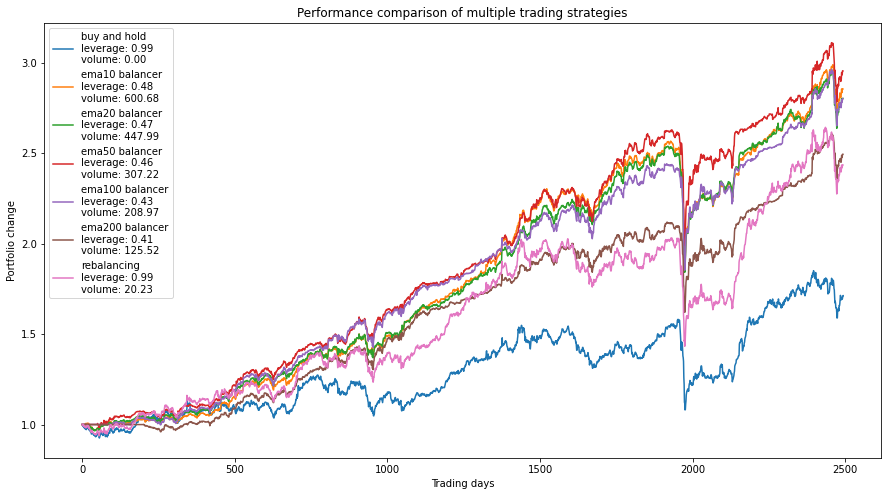

In [34]:
compare_strategies_portfolio(austria_assets, ema_strategies)

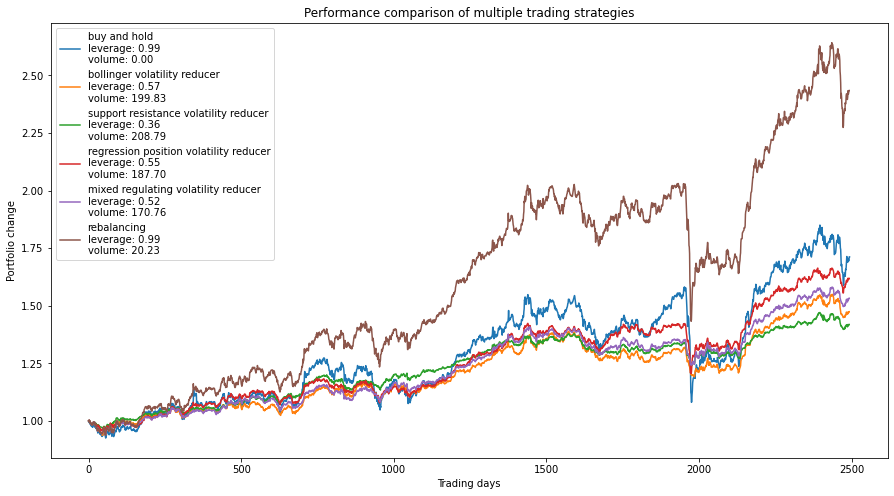

In [35]:
compare_strategies_portfolio(austria_assets, volatility_reducer_strategies)

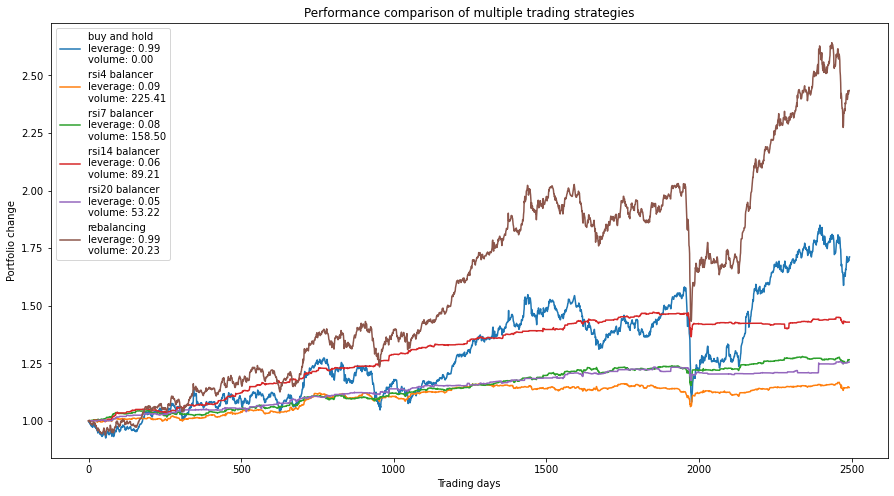

In [36]:
compare_strategies_portfolio(austria_assets, rsi_strategies)

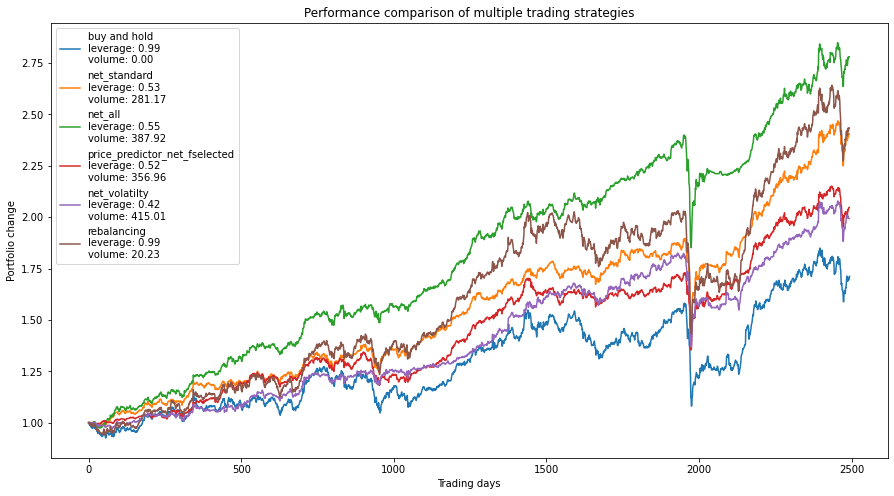

In [37]:
compare_strategies_portfolio(austria_assets, net_strategies)